## Neural Network Agent for Pac Man game
We create a simple neural network agent for Pac Man game. We first initiate a set of random weights and bias and let it play, and choose the agent with the longest time.

Here, the agents don't learn any policy, but relies on initial parameters to make actions(i.e. fixed policy). We use fully connected layers for this problem. The Pac Man has 9 actions -- wait, turn right, turn left, turn up, turn down, go left, go right, go up, go down. So in total, we have 9 output neurons.

In [10]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [11]:
# create a class called RlAgent
class RlAgent:
    def __init__(self,m,n,ini=False,W=None,b=None):
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._X = tf.placeholder(tf.float32,shape=(1,m))
            if ini == False:
                self.W = tf.Variable(tf.random_normal([m,n]),dtype=tf.float32,trainable=False)
                self.bias = tf.Variable(tf.random_normal([1,n]),dtype=tf.float32,trainable=False)
            else:
                self.W = W.astype(np.float32)
                self.bias = b.astype(np.float32)
            out = tf.nn.sigmoid(tf.matmul(self._X,self.W)+self.bias)
            self._result = tf.multinomial(out,1)
            init = tf.global_variables_initializer()
            self._sess = tf.Session()
            self._sess.run(init)
    def predict(self,X):
        action = self._sess.run(self._result,feed_dict={self._X:X})
        return action
    def get_weights(self):
        W, b = self._sess.run([self.W,self.bias])
        return W, b

In [12]:
# for every step the enviroment will return an observation
# with 3 color channels, we preprocess the image by turning it 
# to grey scales and bring better contrast
def preprocess_image(img):
    img = img.mean(axis = 2) # to grayscale
    img[img==150] = 0 # bring about a better contrast
    img = (img-128)/128 - 1 # Normalize image from -1 to 1
    m,n = img.shape
    return img.reshape(1,m*n)

In [13]:
# define the function play_one_episode to play a game
def play_one_episode(env,agent,show=False):
    obs = env.reset()
    img_pre = preprocess_image(obs)
    done = False
    t = 0
    while not done and t < 10000:
        if show == True:
            env.render()
            time.sleep(0.1)
        t += 1
        action = agent.predict(img_pre)
#         print(action)
#         print(t,action)
        obs, reward, done, info = env.step(action)
        img_pre = preprocess_image(obs)
        if done:
            break
    return t

In [14]:
# define an agent with the function play_multiple_episodes,
# let the agent play the game for multiple times and return 
# the average time
def play_multiple_episodes(env, T, ini=False, W=None, b=None):
    episode_lengths = np.empty(T)
    obs = env.reset()
    img_pre = preprocess_image(obs)
    if ini == False:
        agent = RlAgent(img_pre.shape[1],env.action_space.n)
    else:
        agent = RlAgent(img_pre.shape[1],env.action_space.n,ini,W,b)
    for i in range(T):
        episode_lengths[i] = play_one_episode(env,agent)
    avg_length = episode_lengths.mean()
    print('avg length:',avg_length)
    if ini == False:
        W, b = agent.get_weights()
    return avg_length, W, b

In [15]:
# random_search will call play_multiple_episodes, it will create
# agents with random weights and bias every time, and choose the 
# best one as the winner
def random_search(env):
    episode_lengths = []
    best = 0
    for t in range(10):
        print('Agent {} reporting'.format(t))
        avg_length, wts, bias = play_multiple_episodes(env,10)
        episode_lengths.append(avg_length)
        if avg_length > best:
            best_wt = wts
            best_bias = bias
            best = avg_length
    return episode_lengths, best_wt, best_bias

Agent 0 reporting
avg length: 608.9
Agent 1 reporting
avg length: 577.3
Agent 2 reporting
avg length: 653.4
Agent 3 reporting
avg length: 603.8
Agent 4 reporting
avg length: 691.9
Agent 5 reporting
avg length: 725.1
Agent 6 reporting
avg length: 694.2
Agent 7 reporting
avg length: 659.0
Agent 8 reporting
avg length: 764.5
Agent 9 reporting
avg length: 637.7


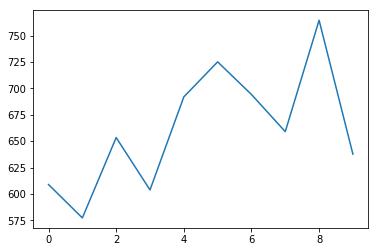

Final Run with Best Agent
avg length: 796.5


(796.5, array([[ 1.7645015 , -0.52955276, -0.43446308, ...,  1.390425  ,
         -0.7595219 , -2.5636916 ],
        [ 1.3779855 ,  1.2355689 , -0.5837271 , ...,  1.2850146 ,
         -0.5818462 , -0.7745538 ],
        [ 0.14610212,  0.67058617,  0.6360966 , ...,  0.1594488 ,
          0.525913  , -0.56968075],
        ...,
        [-1.0270027 , -0.0709662 , -0.77339375, ..., -0.00806218,
          0.17872494, -0.38287705],
        [ 0.50199944,  0.23946403, -2.0853655 , ...,  1.7372761 ,
          0.8750471 ,  0.31531203],
        [ 1.2455478 , -1.604459  ,  1.4156984 , ..., -0.42228484,
          0.60193825, -0.53378403]], dtype=float32), array([[-1.5721787 , -0.35665792, -0.31237945, -0.8790491 , -0.7511816 ,
         -1.560725  ,  0.15768704,  0.8039726 , -0.50674605]],
       dtype=float32))

In [16]:
# env_name = 'Breakout-v0'
env_name = 'MsPacman-v0'
env = gym.make(env_name)
episode_lengths, W, b = random_search(env)
plt.plot(episode_lengths)
plt.show()
print('Final Run with Best Agent')
# print(W.shape,b.shape)
# print(W,b)
play_multiple_episodes(env,10, ini=True,W=W,b=b)

In [17]:
obs = env.reset()
img_pre = preprocess_image(obs)
agent = RlAgent(img_pre.shape[1],env.action_space.n,True,W,b)
play_one_episode(env,agent,show=True)

861

In [18]:
env.close()